In [1]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.imputation import mice
import statsmodels.api as sm

%matplotlib inline

In [2]:

def sigmoid(x):
    #return np.tanh(x)
    return 1/(1+np.exp(-x))

def sigmoid_log(x):
    return sigmoid(np.log(x))

In [3]:
os.chdir("L:/lab_research/RES-Folder-UPOD/Celldynclustering")
celldyn = pd.read_sas("E_ResearchData/2_ResearchData/celldyn.sas7bdat")

D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [4]:
meas_columns = [c for c in celldyn.columns if 'c_b' in c]
mode_columns = [c for c in celldyn.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn if 'c_s_' in c.lower()]

In [8]:
len(celldyn)

3107036

In [5]:
with open("E_ResearchData/2_ResearchData/arm_index_to_take.txt") as f:
    index_to_take = [int(x) for x in f.read().split("\n")[:-1]]

In [6]:
sample_data = celldyn.iloc[index_to_take,:]

<AxesSubplot:>

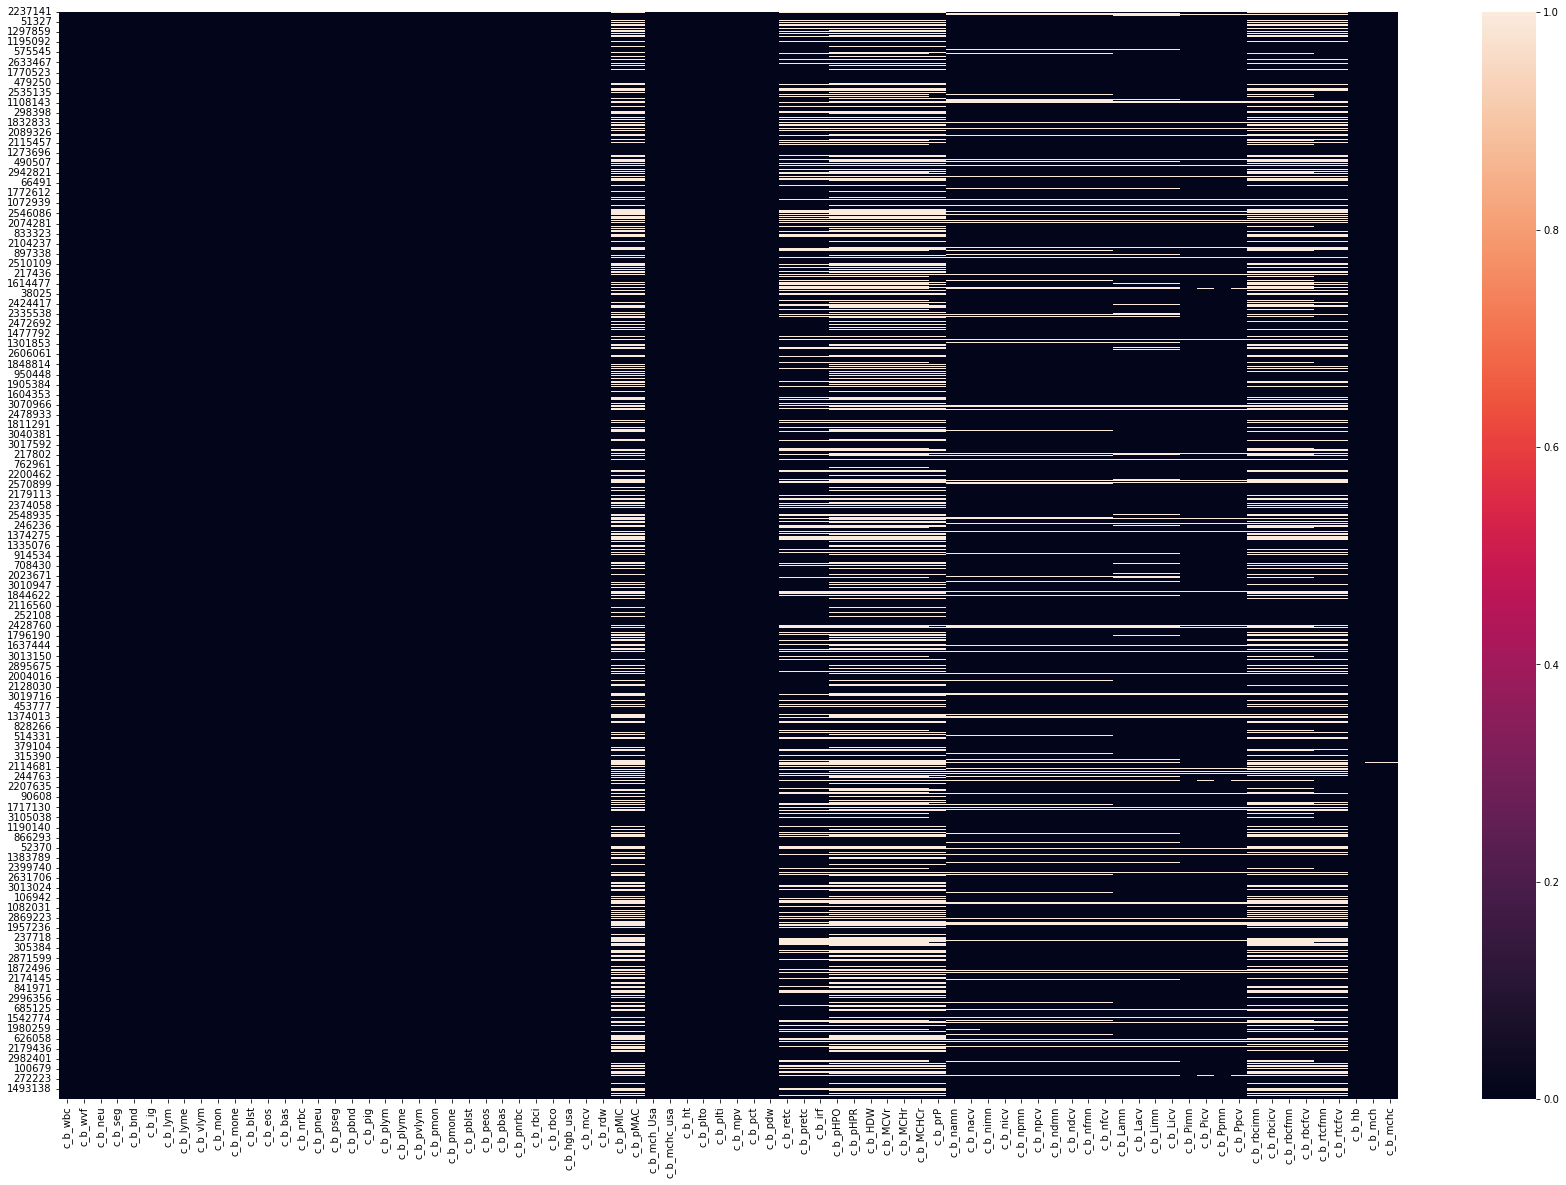

In [7]:
plt.figure(figsize = (30,20))
sns.heatmap(sample_data[meas_columns].isna())

### imputer with all filled cellldyn vars

In [7]:
MICE_preds = [c for c in sample_data[meas_columns].dropna(axis = 1) if 'pMIC' not in c]
imp = mice.MICEData(sample_data[meas_columns])
fml = 'c_b_pMIC ~' + '+'.join(MICE_preds)
mice_imp = mice.MICE(fml, sm.GLM, imp)

In [8]:
results = mice_imp.fit(10, 10)


D:\Miniconda3\envs\embcelldyn\lib\site-packages\statsmodels\imputation\mice.py:979: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)


In [9]:
print(results.summary())

                               Results: MICE
Method:                      MICE            Sample size:            250000
Model:                       GLM             Scale                   13.21 
Dependent variable:          c_b_pMIC        Num. imputations        10    
---------------------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|    [0.025     0.975]   FMI  
---------------------------------------------------------------------------
Intercept      -0.2936   0.1771  -1.6582 0.0973    -0.6407    0.0534 0.6539
c_b_wbc      -401.6049  45.2223  -8.8807 0.0000  -490.2390 -312.9708 0.6842
c_b_wvf        -2.4209   0.3276  -7.3906 0.0000    -3.0629   -1.7789 0.4305
c_b_neu        18.2775 360.8699   0.0506 0.9596  -689.0144  725.5695 0.2407
c_b_seg       383.3303 361.9420   1.0591 0.2896  -326.0629 1092.7236 0.2441
c_b_bnd       383.3225 361.9421   1.0591 0.2896  -326.0710 1092.7161 0.2441
c_b_ig        383.3355 361.9429   1.0591 0.

In [35]:
mice_imp.results_list[-1].fittedvalues

0          0.363240
1          3.886037
2         15.198588
3          1.273215
4          2.091015
            ...    
249995     0.847443
249996     1.485075
249997     2.897484
249998     1.773312
249999     7.319647
Length: 250000, dtype: float64

In [37]:
filled_vals = sample_data.c_b_pMIC.reset_index(drop = True).dropna()

In [ ]:
sns.distplot(filled_vals)
sns.distplot(results[-1].fittedvalues )

D:\Miniconda3\envs\embcelldyn\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='c_b_pMIC'>

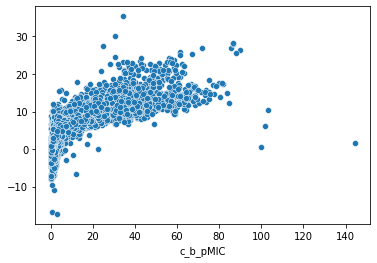

In [38]:
sns.scatterplot(filled_vals,np.mean(np.array([fit_vals.fittedvalues for fit_vals in mice_imp.results_list]),axis = 0)[filled_vals.index])

In [43]:
def rmse(x,y):
    return np.sqrt(np.mean((x-y)**2))

In [44]:
def mape(x,y):
    return (np.mean(abs(x-y)))/np.mean(y)

In [45]:
np.corrcoef(np.mean(np.array([fit_vals.fittedvalues for fit_vals in mice_imp.results_list]),axis = 0)[filled_vals.index],filled_vals)

array([[1.        , 0.75237687],
       [0.75237687, 1.        ]])

In [46]:
mape(np.mean(np.array([fit_vals.fittedvalues for fit_vals in mice_imp.results_list]),axis = 0)[filled_vals.index],filled_vals)

0.5658078126651384